## 世界選手権のデータを可視化する②
---

In [1]:
%matplotlib inline
import pandas as pd
import os
import re
import time
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import time

### パラメータ

In [2]:
# 入力ディレクトリ
input_dir_path = "/Users/takayuki/Documents/work/Study/data/detail_data_year/"
input_file_ext = "results_score.csv"

### ファイルパスのリストを取得

In [3]:
input_file_path_list = []
for root, dirs, files in os.walk(input_dir_path):
    for file in files:
        if input_file_ext in file:
            input_file_path_list.append(os.path.join(root, file))
input_file_path_list

["/Users/takayuki/Documents/work/Study/data/detail_data_year/Capital One World Men's Curling Championship 2010_results_score.csv",
 '/Users/takayuki/Documents/work/Study/data/detail_data_year/CPT World Men’s Curling Championship 2014_results_score.csv',
 '/Users/takayuki/Documents/work/Study/data/detail_data_year/Ford World Curling Championships 2002(Men)_results_score.csv',
 '/Users/takayuki/Documents/work/Study/data/detail_data_year/Ford World Curling Championships 2002(Women)_results_score.csv',
 '/Users/takayuki/Documents/work/Study/data/detail_data_year/Ford World Curling Championships 2003(Men)_results_score.csv',
 '/Users/takayuki/Documents/work/Study/data/detail_data_year/Ford World Curling Championships 2003(Women)_results_score.csv',
 '/Users/takayuki/Documents/work/Study/data/detail_data_year/Ford World Curling Championships 2004(Men)_results_score.csv',
 '/Users/takayuki/Documents/work/Study/data/detail_data_year/Ford World Curling Championships 2004(Women)_results_score.cs

### データの読み込み

In [4]:
start_time = time.time()

# 各試合のスコアデータを格納するDataFrame
result_score_pd = None

# 各ファイルを順に読み込み、DataFrameに格納する
for file_path in input_file_path_list:
    # CSVファイルの読み込み
    tmp_result_score_pd = pd.read_csv(file_path)
    
    # 勝敗フラグの付与（勝ち：1, 引き分け：0, 負け：-1）
    result_score_list = []
    for row_idx in range(0, tmp_result_score_pd.shape[0], 2):
        score1 = tmp_result_score_pd["score(total)"][row_idx]
        score2 = tmp_result_score_pd["score(total)"][row_idx+1]
        
        if tmp_result_score_pd["draw"][row_idx] != tmp_result_score_pd["draw"][row_idx+1]:
            print "draw is different: row {0} and {1}".format(tmp_result_score_pd["draw"][row_idx], tmp_result_score_pd["draw"][row_idx+1])
        elif tmp_result_score_pd["sheet"][row_idx] != tmp_result_score_pd["sheet"][row_idx+1]:
            print "sheet is different: row {0} and {1}".format(tmp_result_score_pd["draw"][row_idx], tmp_result_score_pd["draw"][row_idx+1])
        
        if score1 < score2:
            result_score_list.append(-1)
            result_score_list.append(1)
        elif score1 == score2:
            result_score_list.append(0)
            result_score_list.append(0)
        else:
            result_score_list.append(1)
            result_score_list.append(-1)
        
        # Hammerの修正(先行／後攻がわからない場合)
        hammer1 = tmp_result_score_pd["hammer"][row_idx]
        hammer2 = tmp_result_score_pd["hammer"][row_idx+1]
        if hammer1 == hammer2:
            tmp_result_score_pd["hammer"][row_idx] = -1
            tmp_result_score_pd["hammer"][row_idx+1] = -1
    
    tmp_result_score_pd["result"] = result_score_list
    
    # 年度、性別の取得
    tmp_list = re.findall(r"[0-9]+", file_path)
    if len(tmp_list) != 1 and len(tmp_list[0]) != 4:
        print "Year is missing: {0} {1}".format(file_path, year)
    year = tmp_list[0]
    
    gender = None
    if "Women" in file_path:
        gender = "Women"
    elif "Men" in file_path:
        gender = "Men"
    else:
        print "Gender is missing: row {0}.".format(row_idx)
    
    tmp_result_score_pd["year"] = [year] * tmp_result_score_pd.shape[0]
    tmp_result_score_pd["gender"] = [gender] * tmp_result_score_pd.shape[0]
    
    # DataFrameに追加
    if result_score_pd is None:
        result_score_pd = tmp_result_score_pd
    else:
        result_score_pd = pd.concat([result_score_pd, tmp_result_score_pd])

# データの年数
year_list = list(set(result_score_pd["year"]))
year_list.sort()
print "the number of years : {0}".format(len(year_list))
print year_list

# 年×男or女
year_gender_pd = result_score_pd[["year", "gender"]]
year_gender_pd = year_gender_pd.drop_duplicates()
year_gender_pd = year_gender_pd.sort_values(by=["year", "gender"])
print "\nthe number of competition : {0}".format(year_gender_pd.shape[0])
year_gender_list = []
for value in year_gender_pd.values:
    year_gender_tuple = tuple(value)
    year_gender_list.append(year_gender_tuple)
print year_gender_list

end_time = time.time()
print "\n\tfinish file readeing: {0} [sec]\n".format(end_time - start_time)

SyntaxError: invalid syntax (<ipython-input-4-ff1f44e625b0>, line 18)

### 先行／後攻別の勝ち数

In [ ]:
# 先攻・後攻がわからないゲームは除く
filtered_result_score_pd = result_score_pd[result_score_pd["hammer"] != -1]

# 勝敗数のカウント
cross_table = filtered_result_score_pd.pivot_table(index="hammer", columns="result", values="draw", aggfunc="count")
cross_table["winning_percentage"] = cross_table[1] / (cross_table[-1] + cross_table[1])
print "全試合："
print cross_table

# 二項検定
p_value = scipy.stats.binom_test([cross_table.ix[1, -1], cross_table.ix[1, 1]], p=0.5)
print "\n二項検定（帰無仮説：先行と後攻で勝率は変わらない, p=0.5）："
print "p value: {0}".format(p_value)

# 男女別
mens_result_score_pd = filtered_result_score_pd[filtered_result_score_pd["gender"] =="Men"]
mens_cross_table = mens_result_score_pd.pivot_table(index="hammer", columns="result", values="draw", aggfunc="count")
mens_cross_table["winning_percentage"] = mens_cross_table[1] / (mens_cross_table[-1] + mens_cross_table[1])
print "\n男子："
print mens_cross_table

womens_result_score_pd = filtered_result_score_pd[filtered_result_score_pd["gender"] =="Women"]
womens_cross_table = womens_result_score_pd.pivot_table(index="hammer", columns="result", values="draw", aggfunc="count")
womens_cross_table["winning_percentage"] = womens_cross_table[1] / (womens_cross_table[-1] + womens_cross_table[1])
print "\n女子："
print womens_cross_table

### 各国の先行／後攻別の勝率

勝率(Japan)：
result  hammer    -1     1  winning_percentage
22           0  65.0  40.0            0.380952
23           1  57.0  39.0            0.406250

勝率(Canada)：
result  hammer    -1      1  winning_percentage
4            0  47.0  118.0            0.715152
5            1  36.0  162.0            0.818182

x2検定（勝敗と先行／後攻）
日本：
  x2値：0.049386195454
  p値：0.82413480183

カナダ：
  x2値：4.84846062823
  p値：0.0276708165193

各国の先攻・後攻での勝率の散布図：


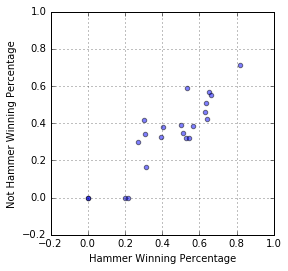


先攻の勝率 ＞ 後攻の勝率
              team  hammer_winning_percentage  not_hammer_winning_percentage
0        Australia                   0.300000                       0.416667
4   Czech Republic                   0.268657                       0.296296
12           Korea                   0.305556                       0.339623
15     New Zealand                   0.533333                       0.588235


In [6]:
# 国別に集計
cross_table = filtered_result_score_pd.pivot_table(index=["team", "hammer"], columns="result", values="draw", aggfunc="count")

# NaNは0勝または0敗に変換
cross_table[1] = [x if x == x else 0 for x in cross_table[1]]
cross_table[-1] = [x if x == x else 0 for x in cross_table[-1]]

# indexを振り直す
cross_table.reset_index(inplace=True)

# 勝率を計算
cross_table["winning_percentage"] = cross_table[1] / (cross_table[-1] + cross_table[1])

# 日本、カナダの勝率
print "勝率(Japan)："
print cross_table.ix[cross_table["team"] == "Japan"][["hammer", -1, 1, "winning_percentage"]]
print "\n勝率(Canada)："
print cross_table.ix[cross_table["team"] == "Canada"][["hammer", -1, 1, "winning_percentage"]]

# カイ二乗検定
print "\nx2検定（勝敗と先行／後攻）"

# 日本
cross_tab_jp = cross_table.ix[cross_table["team"] == "Japan"][[-1, 1]]
cross_tab_jp.index = cross_table[cross_table["team"] == "Japan"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_jp)
print "日本："
print "  x2値：{0}".format(x2)
print "  p値：{0}".format(p)

# カナダ
cross_tab_ca = cross_table.ix[cross_table["team"] == "Canada"][[-1, 1]]
cross_tab_ca.index = cross_table[cross_table["team"] == "Canada"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_ca)
print "\nカナダ："
print "  x2値：{0}".format(x2)
print "  p値：{0}".format(p)


# 先行・後攻の勝率リスト
hammer_win_percentage_list = cross_table[cross_table["hammer"] == 1]["winning_percentage"]
not_hammer_win_percentage_list = cross_table[cross_table["hammer"] == 0]["winning_percentage"]

# 散布図の描画
print "\n各国の先攻・後攻での勝率の散布図："
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(hammer_win_percentage_list, not_hammer_win_percentage_list, alpha=0.5)

# 軸ラベル
ax.set_xlabel("Hammer Winning Percentage")
ax.set_ylabel("Not Hammer Winning Percentage")

# 描画範囲の設定
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
if x_min < y_min:
    y_min = x_min
else:
    x_min = y_min
if x_max < y_max:
    x_max = y_max
else:
    y_max = x_max
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# 縦横比の調整
ax.set_aspect(aspect='equal')

# グリッド線の描画
plt.grid()

# 描画
plt.show()

# 先攻の方が勝率が高い国
hammer_pd = cross_table[cross_table["hammer"] == 1][["team", "winning_percentage"]]
hammer_pd.columns = ["team", "hammer_winning_percentage"]
not_hammer_pd = cross_table[cross_table["hammer"] == 0][["team", "winning_percentage"]]
not_hammer_pd.columns = ["team", "not_hammer_winning_percentage"]
win_percentage_pd = pd.merge(hammer_pd, not_hammer_pd, on="team")
print "\n先攻の勝率 ＞ 後攻の勝率"
print win_percentage_pd[win_percentage_pd["hammer_winning_percentage"] < win_percentage_pd["not_hammer_winning_percentage"]]

In [7]:
# カイ二乗検定
print "\nx2検定（勝敗と先行／後攻）"

# オーストラリア
cross_tab_au = cross_table.ix[cross_table["team"] == "Australia"][[-1, 1]]
cross_tab_au.index = cross_table[cross_table["team"] == "Australia"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_au)
print "オーストラリア："
print "  x2値：{0}".format(x2)
print "  p値：{0}".format(p)

# チェコ
print 
cross_tab_cz = cross_table.ix[cross_table["team"] == "Czech Republic"][[-1, 1]]
cross_tab_cz.index = cross_table[cross_table["team"] == "Czech Republic"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_cz)
print "チェコ："
print "  x2値：{0}".format(x2)
print "  p値：{0}".format(p)

# 韓国
print 
cross_tab_kr = cross_table.ix[cross_table["team"] == "Korea"][[-1, 1]]
cross_tab_kr.index = cross_table[cross_table["team"] == "Korea"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_kr)
print "韓国："
print "  x2値：{0}".format(x2)
print "  p値：{0}".format(p)

# ニュージーランド
print 
cross_tab_nz = cross_table.ix[cross_table["team"] == "New Zealand"][[-1, 1]]
cross_tab_nz.index = cross_table[cross_table["team"] == "New Zealand"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_nz)
print "ニュージーランド："
print "  x2値：{0}".format(x2)
print "  p値：{0}".format(p)


x2検定（勝敗と先行／後攻）
オーストラリア：
  x2値：0.236532738095
  p値：0.626721646734

チェコ：
  x2値：0.017640578753
  p値：0.894337444691

韓国：
  x2値：0.0112660094219
  p値：0.915470117005

ニュージーランド：
  x2値：0.00199190787426
  p値：0.964401596142


### 各エンドで得点したチームの勝率

In [8]:
start_time = time.time()

# endのカラム名リスト
end_column_list = filter(lambda x: re.match(r"end*", x), list(result_score_pd.columns))

# 各エンドの型を数値に変換
for end in end_column_list:
    if result_score_pd[end].dtype != np.int:
        result_score_pd[end] = result_score_pd[end].apply(lambda x: int(x) if isinstance(x, str) and x.isdigit() else -10)

# 0点を失点とブランクエンド(0)に分ける
renew_result_score_pd = result_score_pd.copy()
column_list = list(renew_result_score_pd.columns)
for row_idx in range(0, renew_result_score_pd.shape[0], 2):
    row1 = renew_result_score_pd.iloc[row_idx, :]
    row2 = renew_result_score_pd.iloc[row_idx+1, :]
    
    # 同じゲームのレコードであるか確認
    if row1["draw"] != row2["draw"]:
        print "draw is different: row {0} and {1}".format(row1["draw"], row2["draw"])
    elif row1["sheet"] != row2["sheet"]:
        print "sheet is different: row {0} and {1}".format(tmp_result_score_pd["draw"][row_idx], tmp_result_score_pd["draw"][row_idx+1])
    
    for target_column in end_column_list:
        target_column_idx = column_list.index(target_column)

        end_score1 = row1[target_column_idx]
        end_score2 = row2[target_column_idx]
        # ブランクエンドかチェック
        blank_end = False
        if end_score1 == end_score2 == 0:
            blank_end = True
        # 失点の場合
        if not blank_end:
            if end_score1 == 0:
                #end_score1 = -1 * renew_result_score_pd.iloc[row_idx+1, target_column_idx]
                end_score1 = -1 * end_score2
                renew_result_score_pd.iloc[row_idx, target_column_idx] = end_score1
            if end_score2 == 0:
                #end_score2 = -1 * renew_result_score_pd.iloc[row_idx, target_column_idx]
                end_score2 = -1 * end_score1
                renew_result_score_pd.iloc[row_idx+1, target_column_idx] = end_score2
        # 3点以上はビッグエンドとして3にまとめる
        if end_score1 >= 3:
            renew_result_score_pd.iloc[row_idx, target_column_idx] = 3
        if end_score1 <= -3:
            renew_result_score_pd.iloc[row_idx, target_column_idx] = -3
        if end_score2 >= 3:
            renew_result_score_pd.iloc[row_idx+1, target_column_idx] = 3
        if end_score2 <= -3:
            renew_result_score_pd.iloc[row_idx+1, target_column_idx] = -3

end_time = time.time()
print "\n\tfinish data transform: {0} [sec]\n".format(end_time - start_time)


	finish data transform: 18.54925704 [sec]



In [13]:
winning_percentage_pd = None
not_hammer_winning_percentage_pd = None
hammer_winning_percentage_pd = None

for target_column in end_column_list:
    end_scoring_pd = renew_result_score_pd.pivot_table(index=target_column, columns="result", values="draw", aggfunc="count")
    end_scoring_pd.reset_index(inplace=True)
    end_scoring_pd.columns.name = "#"
    end_scoring_pd = end_scoring_pd.where(end_scoring_pd == end_scoring_pd, 0)
    end_scoring_pd["winning_percentage"] = end_scoring_pd[1] / (end_scoring_pd[-1] + end_scoring_pd[1])
    end_scoring_pd = end_scoring_pd[[target_column, "winning_percentage"]]
    if winning_percentage_pd is None:
        winning_percentage_pd = end_scoring_pd
        winning_percentage_pd.columns = ["score", target_column]
    else:
        end_scoring_pd.columns = ["score", target_column]
        winning_percentage_pd = pd.merge(winning_percentage_pd, end_scoring_pd, on="score", how="outer")

    # 先行の場合
    not_hammer_end_scoring_pd = renew_result_score_pd[renew_result_score_pd["hammer"] != 1].pivot_table(index=target_column, columns="result",
                                                                                                      values="draw", aggfunc="count")
    not_hammer_end_scoring_pd.reset_index(inplace=True)
    not_hammer_end_scoring_pd.columns.name = "#"
    not_hammer_end_scoring_pd = not_hammer_end_scoring_pd.where(not_hammer_end_scoring_pd == not_hammer_end_scoring_pd, 0)
    not_hammer_end_scoring_pd["winning_percentage"] = not_hammer_end_scoring_pd[1] / (not_hammer_end_scoring_pd[-1] + not_hammer_end_scoring_pd[1])
    not_hammer_end_scoring_pd = not_hammer_end_scoring_pd[[target_column, "winning_percentage"]]
    if not_hammer_winning_percentage_pd is None:
        not_hammer_winning_percentage_pd = not_hammer_end_scoring_pd
        not_hammer_winning_percentage_pd.columns = ["score", target_column]
    else:
        not_hammer_end_scoring_pd.columns = ["score", target_column]
        not_hammer_winning_percentage_pd = pd.merge(not_hammer_winning_percentage_pd, not_hammer_end_scoring_pd, on="score", how="outer")

    # 後攻の場合
    hammer_end_scoring_pd = renew_result_score_pd[renew_result_score_pd["hammer"] == 1].pivot_table(index=target_column, columns="result",
                                                                                                  values="draw", aggfunc="count")
    hammer_end_scoring_pd.reset_index(inplace=True)
    hammer_end_scoring_pd.columns.name = "#"
    hammer_end_scoring_pd = hammer_end_scoring_pd.where(hammer_end_scoring_pd == hammer_end_scoring_pd, 0)
    hammer_end_scoring_pd["winning_percentage"] = hammer_end_scoring_pd[1] / (hammer_end_scoring_pd[-1] + hammer_end_scoring_pd[1])
    hammer_end_scoring_pd = hammer_end_scoring_pd[[target_column, "winning_percentage"]]
    if hammer_winning_percentage_pd is None:
        hammer_winning_percentage_pd = hammer_end_scoring_pd
        hammer_winning_percentage_pd.columns = ["score", target_column]
    else:
        hammer_end_scoring_pd.columns = ["score", target_column]
        hammer_winning_percentage_pd = pd.merge(hammer_winning_percentage_pd, hammer_end_scoring_pd, on="score", how="outer")
    
    print "\tfinish {0}".format(target_column)

winning_percentage_pd = winning_percentage_pd.set_index("score")
not_hammer_winning_percentage_pd = not_hammer_winning_percentage_pd.set_index("score")
hammer_winning_percentage_pd = hammer_winning_percentage_pd.set_index("score")

print "\n全体："
print winning_percentage_pd
print "\n先行："
print not_hammer_winning_percentage_pd
print "\n後攻："
print hammer_winning_percentage_pd

	finish end1
	finish end2
	finish end3
	finish end4
	finish end5
	finish end6
	finish end7
	finish end8
	finish end9
	finish end10

全体：
           end1      end2      end3      end4      end5      end6      end7  \
score                                                                         
-3     0.154472  0.220000  0.223350  0.156757  0.180328  0.151515  0.367220   
-2     0.247031  0.382643  0.382294  0.372510  0.389864  0.399590  0.383028   
-1     0.468790  0.511654  0.529475  0.542390  0.515676  0.549251  0.518857   
 0     0.500000  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
 1     0.531210  0.488346  0.470588  0.457610  0.484324  0.450749  0.481143   
 2     0.752969  0.617357  0.617706  0.627490  0.610136  0.600410  0.616972   
 3     0.845528  0.780000  0.776650  0.843243  0.819672  0.848485  0.851648   

           end8      end9     end10  
score                                
-3     0.387273  0.447545  0.480826  
-2     0.379845  0.452785  0.205534  


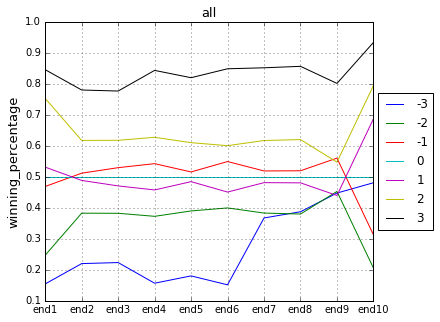

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)

winning_percentage_pd.T.plot(ax=ax, figsize=(20, 5))

# 凡例の位置を調整
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
# グリッド線を表示
plt.grid()
# タイトル、y軸
ax.set_title("all", fontsize=13)
ax.set_ylabel("winning_percentage", fontsize=13)
# 
#ax.set_aspect(aspect="equal")

plt.show()

1エンド目の得点別勝率（全体、先行、後攻）：
            all  not_hammer    hammer
score                                
-3     0.154472    0.130000  0.260870
-2     0.247031    0.247340  0.244444
-1     0.468790    0.505282  0.373272
 0     0.500000    0.421245  0.579336
 1     0.531210    0.619910  0.496454
 2     0.752969    0.750000  0.753351
 3     0.845528    0.739130  0.870000


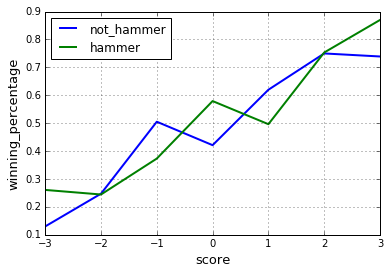

In [26]:
winning_percentage_pd = None
not_hammer_winning_percentage_pd = None
hammer_winning_percentage_pd = None

for target_column in end_column_list:
    end_scoring_pd = renew_result_score_pd.pivot_table(index=target_column, columns="result", values="draw", aggfunc="count")
    end_scoring_pd.reset_index(inplace=True)
    end_scoring_pd.columns.name = "#"
    end_scoring_pd = end_scoring_pd.where(end_scoring_pd == end_scoring_pd, 0)
    end_scoring_pd["winning_percentage"] = end_scoring_pd[1] / (end_scoring_pd[-1] + end_scoring_pd[1])
    end_scoring_pd = end_scoring_pd[[target_column, "winning_percentage"]]
    if winning_percentage_pd is None:
        winning_percentage_pd = end_scoring_pd
        winning_percentage_pd.columns = ["score", target_column]
    else:
        end_scoring_pd.columns = ["score", target_column]
        winning_percentage_pd = pd.merge(winning_percentage_pd, end_scoring_pd, on="score", how="outer")

    # 先行の場合
    not_hammer_end_scoring_pd = renew_result_score_pd[renew_result_score_pd["hammer"] != 1].pivot_table(index=target_column, columns="result",
                                                                                                      values="draw", aggfunc="count")
    not_hammer_end_scoring_pd.reset_index(inplace=True)
    not_hammer_end_scoring_pd.columns.name = "#"
    not_hammer_end_scoring_pd = not_hammer_end_scoring_pd.where(not_hammer_end_scoring_pd == not_hammer_end_scoring_pd, 0)
    not_hammer_end_scoring_pd["winning_percentage"] = not_hammer_end_scoring_pd[1] / (not_hammer_end_scoring_pd[-1] + not_hammer_end_scoring_pd[1])
    not_hammer_end_scoring_pd = not_hammer_end_scoring_pd[[target_column, "winning_percentage"]]
    if not_hammer_winning_percentage_pd is None:
        not_hammer_winning_percentage_pd = not_hammer_end_scoring_pd
        not_hammer_winning_percentage_pd.columns = ["score", target_column]
    else:
        not_hammer_end_scoring_pd.columns = ["score", target_column]
        not_hammer_winning_percentage_pd = pd.merge(not_hammer_winning_percentage_pd, not_hammer_end_scoring_pd, on="score", how="outer")

    # 後攻の場合
    hammer_end_scoring_pd = renew_result_score_pd[renew_result_score_pd["hammer"] == 1].pivot_table(index=target_column, columns="result",
                                                                                                  values="draw", aggfunc="count")
    hammer_end_scoring_pd.reset_index(inplace=True)
    hammer_end_scoring_pd.columns.name = "#"
    hammer_end_scoring_pd = hammer_end_scoring_pd.where(hammer_end_scoring_pd == hammer_end_scoring_pd, 0)
    hammer_end_scoring_pd["winning_percentage"] = hammer_end_scoring_pd[1] / (hammer_end_scoring_pd[-1] + hammer_end_scoring_pd[1])
    hammer_end_scoring_pd = hammer_end_scoring_pd[[target_column, "winning_percentage"]]
    if hammer_winning_percentage_pd is None:
        hammer_winning_percentage_pd = hammer_end_scoring_pd
        hammer_winning_percentage_pd.columns = ["score", target_column]
    else:
        hammer_end_scoring_pd.columns = ["score", target_column]
        hammer_winning_percentage_pd = pd.merge(hammer_winning_percentage_pd, hammer_end_scoring_pd, on="score", how="outer")
    
winning_percentage_pd = winning_percentage_pd.set_index("score")
not_hammer_winning_percentage_pd = not_hammer_winning_percentage_pd.set_index("score")
hammer_winning_percentage_pd = hammer_winning_percentage_pd.set_index("score")

merge_win_per_pd = pd.DataFrame([winning_percentage_pd["end1"], not_hammer_winning_percentage_pd["end1"], hammer_winning_percentage_pd["end1"]]).T
merge_win_per_pd.columns = ["all", "not_hammer", "hammer"]

print "1エンド目の得点別勝率（全体、先行、後攻）："
print merge_win_per_pd

# グラフ描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

merge_win_per_pd[["not_hammer", "hammer"]].plot(ax=ax, figsize=(6, 4), lw=2)

# グリッド線を表示
plt.grid()
# x軸、y軸
ax.set_xlabel("score", fontsize=13)
ax.set_ylabel("winning_percentage", fontsize=13)
# 
#ax.set_aspect(aspect="equal")

plt.show()